In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import shap
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Adding because 3rd party imports are causing deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
shap.initjs()

/home/mluser/code/secom/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Reading Data and preparing DataFrames

## Data Description
Data: 1567 examples with 591 features.

Labels: Pass = -1, Fail = 1, imbalanced.

## Features of interest 
F071, F239, F306 and F357

In [4]:
data = pd.read_csv('data/secom.data', header=None, sep=' ')
labels_time = pd.read_csv('data/secom_labels.data', header=None, sep=' ')

In [5]:
labels_time.columns = ['target', 'time']
labels_time['time'] = pd.to_datetime(labels_time['time'])
feature_columns = [f'F{i+1:03}' for i in range(data.shape[1])]
data.columns = feature_columns
labels = labels_time[['target']]

## Ratio of classes

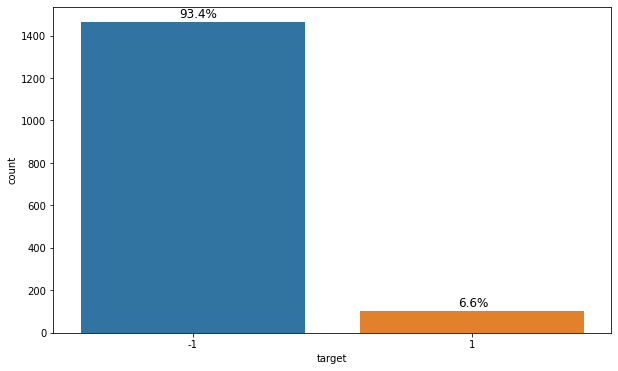

In [6]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x=labels.target)

total = labels.shape[0]
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 20
    ax.annotate(percentage, (x, y), size = 12)

In [7]:
seed = 43

## Variables of interest
### F071, F239, F306 and F357

In [8]:
expensive_sensors = ['F071', 'F239', 'F306', 'F357']

## Splitting the data to create train and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.25, random_state=seed, stratify=labels)

## Remove columns based on missing values
### Using threshold of > 40% missing values

In [10]:
# X_train.isna().sum().sort_values(ascending=False).head(10)

def remove_columns_na(df, threshold):
    columns = df.columns[(df.isna().sum()/df.shape[1]) > threshold]
    return columns.tolist()

na_columns = remove_columns_na(X_train, 0.4)

X_train_nona = X_train.drop(columns=na_columns)
X_test_nona = X_test.drop(columns=na_columns)

### Visualising a sub-sample of bad vs. good features in terms of missing values 

<AxesSubplot:>

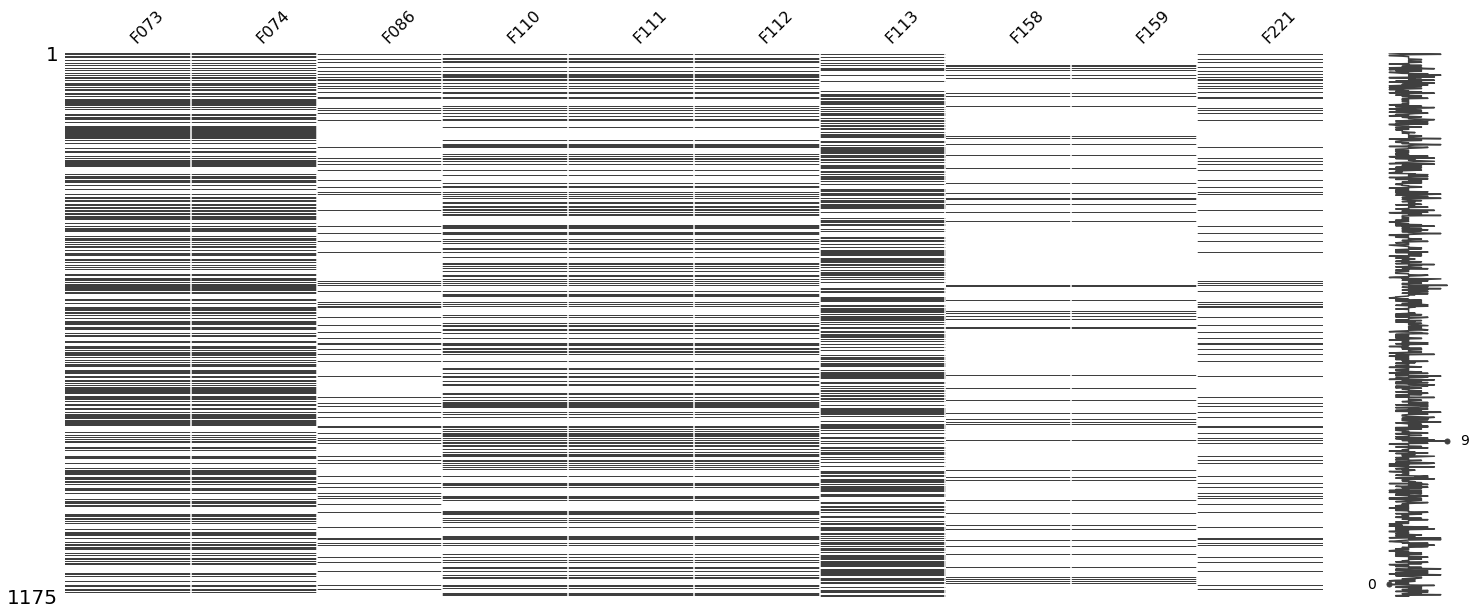

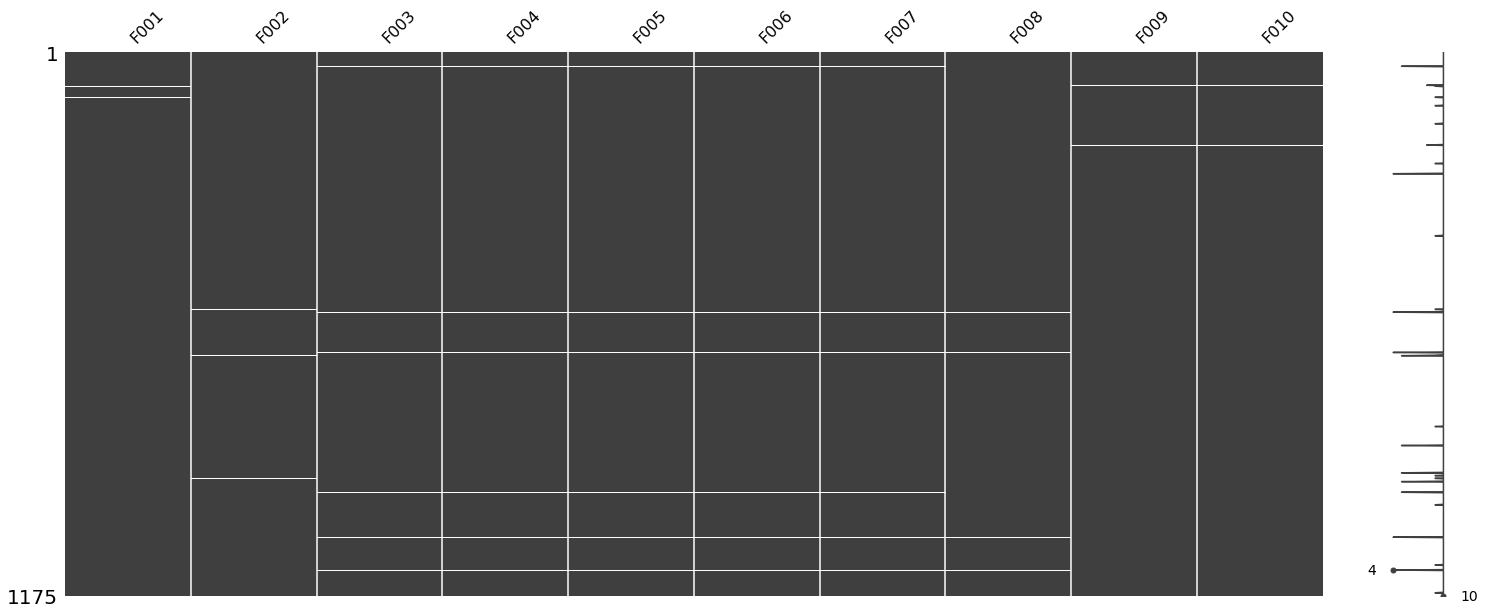

In [11]:
na_data = X_train[na_columns]
nona_data = X_train[X_train.columns.difference(na_columns)]
msno.matrix(na_data.iloc[:,0:10])
msno.matrix(nona_data.iloc[:,0:10])

In [12]:
VarianceThreshold??

## Removing columns with constant values

In [13]:
print(f'Data shape before dropping constant columns: {X_train_nona.shape}')
X_train_nona_non_const = X_train_nona.fillna(X_train_nona.median())
const_cols = X_train_nona_non_const.columns[X_train_nona_non_const.nunique() <= 1]

# Dropping columns in the original DF, not the one imputed with median
X_train_non_const = X_train_nona.drop(const_cols, axis=1)
X_test_non_const = X_test_nona.drop(const_cols, axis=1)
print(f'Data shape after dropping constant columns: {X_train_non_const.shape}')
X_train_non_const.describe()

Data shape before dropping constant columns: (1175, 558)
Data shape after dropping constant columns: (1175, 442)


,F001,F002,F003,F004,F005,F007,F008,F009,F010,F011,...,F577,F578,F583,F584,F585,F586,F587,F588,F589,F590
count,1170.000000,1169.000000,1164.000000,1164.000000,1164.000000,1164.000000,1167.000000,1173.000000,1173.000000,1173.000000,...,1175.000000,1175.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,3012.282009,2498.807263,2200.784872,1392.557124,5.157906,101.058194,0.121664,1.463364,-0.000648,0.000165,...,5.912284,16.920493,0.500124,0.015128,0.003804,3.027643,0.021347,0.016507,0.005291,101.990615
std,73.558464,81.013100,29.402288,428.515522,65.072949,6.103035,0.009644,0.074182,0.014956,0.009405,...,17.673908,13.063979,0.003362,0.014424,0.003102,2.992419,0.012340,0.008775,0.002862,98.488317
min,2743.240000,2162.870000,2060.660000,0.000000,0.681500,82.131100,0.000000,1.191000,-0.047200,-0.032900,...,0.663600,4.582000,0.480000,0.006500,0.001800,1.284500,-0.006000,0.003200,0.001000,0.000000
25%,2964.957500,2453.970000,2182.313875,1081.566200,1.020375,97.762200,0.121000,1.412900,-0.010800,-0.005700,...,1.398100,11.624900,0.498000,0.011525,0.003100,2.305300,0.013400,0.010600,0.003300,44.368600
50%,3007.610000,2501.030000,2201.466650,1287.353800,1.317100,101.460000,0.122300,1.461600,-0.001000,0.000400,...,1.620000,13.897900,0.500100,0.013700,0.003600,2.748700,0.020300,0.014800,0.004600,73.854450
75%,3055.425000,2541.120000,2218.055500,1590.192350,1.529600,104.468600,0.123800,1.516900,0.008600,0.006300,...,1.902000,17.187450,0.502300,0.016500,0.004100,3.295175,0.027575,0.020475,0.006400,116.108800
max,3356.350000,2846.440000,2315.266700,3619.739700,1114.536600,129.252200,0.127600,1.656400,0.074900,0.053000,...,90.423500,96.960100,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800


## Imputing missing values using KNNImputer
Here, we can use many other methods, starting from filling with zeros, means, medians or training individual
models for imputing each feature

In [14]:
imputer = KNNImputer()
imputer.fit(X_train_non_const)
X_train_imp = pd.DataFrame(imputer.transform(X_train_non_const), columns = X_train_non_const.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_non_const), columns = X_test_non_const.columns)

## Other approaches 
A number of other methods can be applied to further reduce the dimentionality, for instance (but not limited to) : 
- Correlations with the target => remove features that have very low correlation with the target
- Correlations within features => We typically don't want to keep features that give us the same / similar information
- Recursive Feature Elimination => Trains a model iteratively to remove features one by one (or in groups) based on their relative information gain

## Removing correlated columns
We are going to remove columns which are highly correlated. This is not a causal relationship, but we know that if two sensors are highly correlated, we are not going to lose much information by removing one of them. 

We also look at the expensive sensors specifically.

In [15]:
def identify_correlated_columns(data, threshold: float = 0.9, banned_columns: list = None): 
    col_corr = set()
    corr_matrix = data.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
                
            if abs(corr_matrix.iloc[i, j]) > threshold:
                if corr_matrix.columns[i] in banned_columns or corr_matrix.columns[j] in banned_columns:
                    print(corr_matrix.columns[i], corr_matrix.columns[j])
                    
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr

correlated_columns = identify_correlated_columns(X_train_imp, threshold=0.95, banned_columns=expensive_sensors)

F306 F171
F357 F219
F377 F239
F442 F306


We can see the following : 

- **F239** is higly correlated with **F377** (>95%)
- **F306** is higly correlated with **F171** and **F442** (>95%)
- **F357** is higly correlated with **F219** (>95%)
- **F071** is higly correlated with **F067** (~91% but with some outliers in **F067**) and several others > 70% 

Conclusion: 
- Investigate if these are really outliers or not by consulting the client. 
    - For the purpose of this analysis, we can simply remove points > 3$\sigma$ of train set from train and test set
- Try to explain anyway, just to test some methods (below)

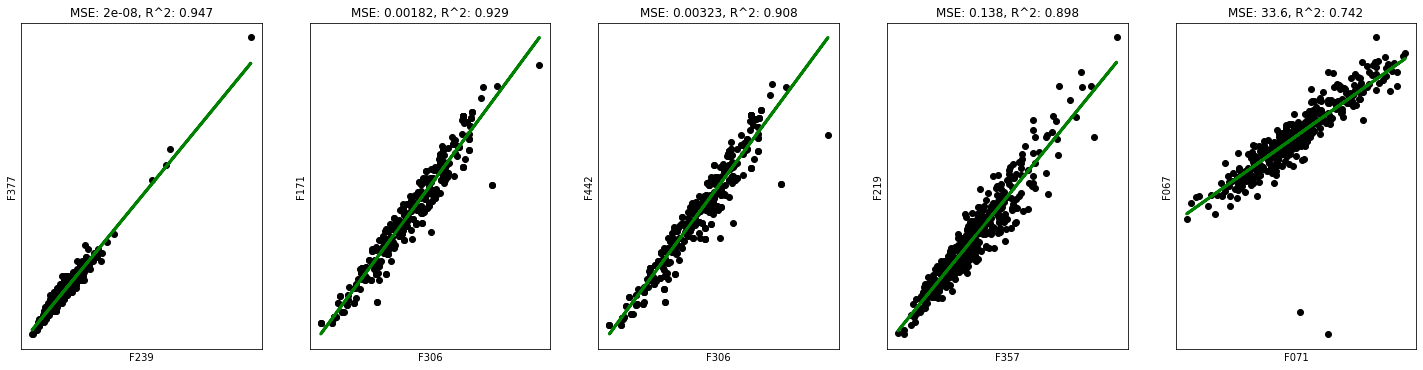

In [16]:
plot_pairs = [('F239', 'F377'), ('F306', 'F171'), ('F306', 'F442'), ('F357', 'F219'), ('F071', 'F067')]

def plot_linear_regression(feature_pairs):
    fig = plt.figure(figsize=(5*len(feature_pairs), 6))
    
    for i in range(len(feature_pairs)):
        x, y = feature_pairs[i]
        plt.subplot(1, len(feature_pairs), i+1)
        
        reg = LinearRegression().fit(X_train_imp[[x]], X_train_imp[y])
        test_pred = reg.predict(X_test_imp[[x]])

        mse = mean_squared_error(X_test_imp[y], test_pred)
        r2 = r2_score(X_test_imp[y], test_pred)
        
        # Plot outputs
        plt.scatter(X_test_imp[x], X_test_imp[y], color="black")
        plt.plot(X_test_imp[x], test_pred, color="green", linewidth=3)

        plt.xticks(())
        plt.yticks(())
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'MSE: {mse:.3}, R^2: {r2:.3}')

    plt.show()

plot_linear_regression(plot_pairs)

In [17]:
X_train_clean = X_train_imp.drop(correlated_columns, axis=1)
X_test_clean = X_test_imp.drop(correlated_columns, axis=1)

In [18]:
print(X_train_clean.shape)

(1175, 263)


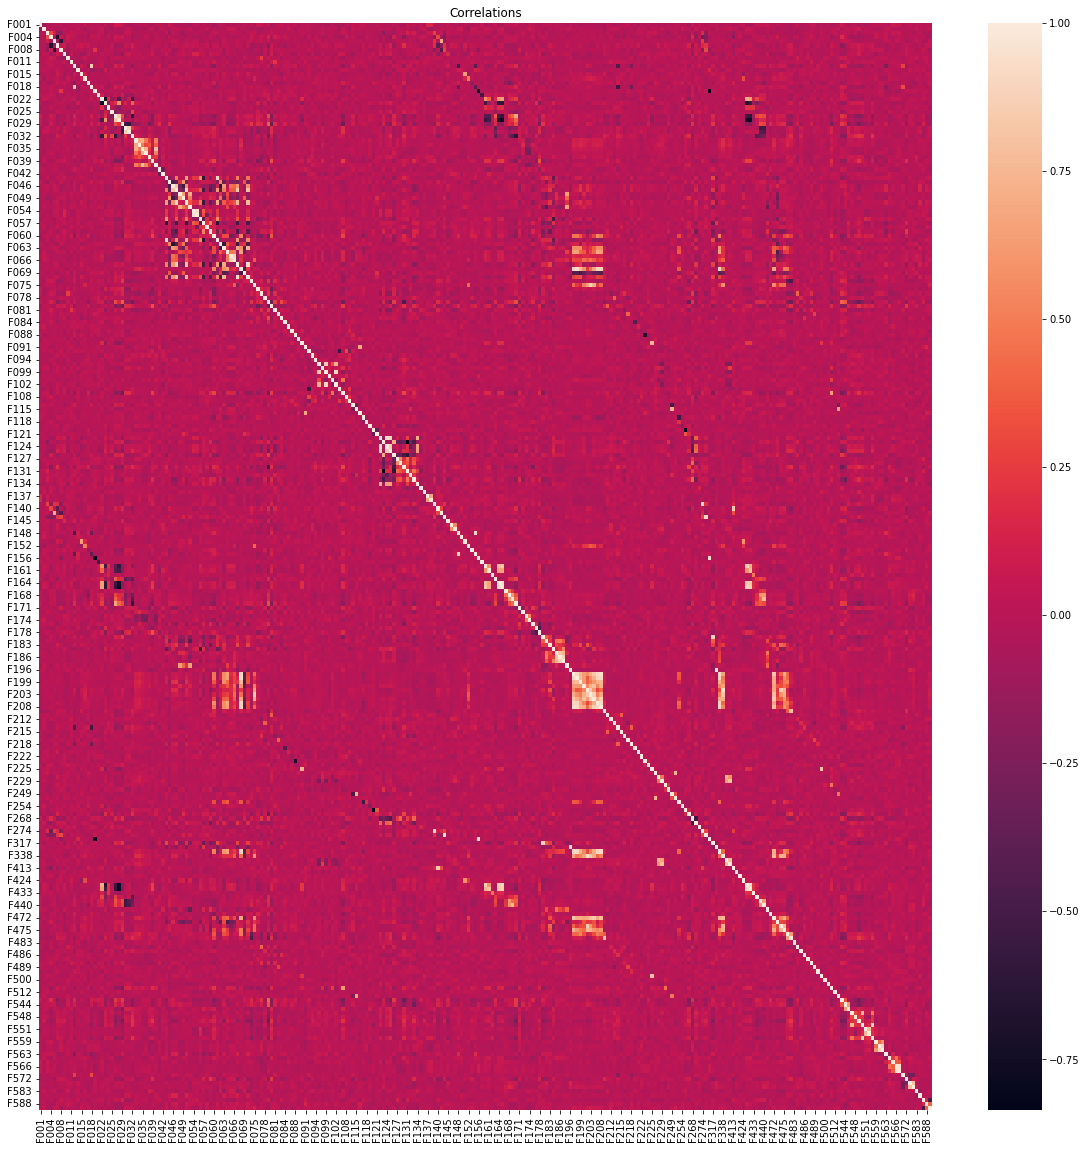

In [19]:
fig = plt.figure(figsize=(20, 20))
# correlations = X_train_clean[list(X_train_clean.columns)[0:20]].corr()
correlations = X_train_clean.corr()
sns.heatmap(correlations)
plt.title('Correlations')
plt.show()

In [21]:
# fig = plt.figure(figsize=(5*len(expensive_sensors), 5))
# for i in range(len(expensive_sensors)):
#     plt.subplot(1, len(expensive_sensors), i+1)
#     sns.histplot(x=X_train_clean[expensive_sensors[i]])

##  Trying to explain F071

A couple of ways to try to tackle this come to mind. 
- Simplest is to show which sensors are higly correlated
- PCA to find reduced dimensions, along with visualisations to show the explained variances with each PC along with sensors that are impacting each PC should lead to clear understanding through domain knowledge. 
- Another approach is to try and train a regression model with the sensor as the target and the remaining features as X. This can be followed with a bunch of things to explain the model: 
    - Choosing a readily explainable model would be preferred, such as Tree based models. 
    - Feature importances would give a clear understanding of what sensors are important to predict the value of this sensor.
    - Further explainability tools and visualisations can be applied to demonstrate the relations. 
    
While this is probably overkill, I've gone into the last two approaches below. 

In [20]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_clean), columns=X_test_clean.columns)
print(X_train_scaled.shape, X_test_scaled.shape)

(1175, 263) (392, 263)


In [21]:
# Creating new data for training a regression between F071 and the rest
y_train_71 = X_train_scaled['F071']
X_train_71 = X_train_scaled.drop(['F071'], axis=1)

X_sub_train_71, X_valid_71, y_sub_train_71, y_valid_71 = train_test_split(X_train_71, y_train_71, test_size=0.2)

y_test_71 = X_test_scaled['F071']
X_test_71 = X_test_scaled.drop(['F071'], axis=1)
print(X_train_71.shape, X_sub_train_71.shape, X_valid_71.shape, X_test_71.shape)

(1175, 262) (940, 262) (235, 262) (392, 262)


In [22]:
xgb_71 = xgb.XGBRegressor(
    learning_rate=0.02, 
    subsample=0.2, 
    colsample_bytree=0.5, 
    n_estimators=1000, 
    base_score=y_sub_train_71.mean())

In [23]:
xgb_71.fit(X_sub_train_71, y_sub_train_71, eval_set=[(X_valid_71, y_valid_71)], 
           eval_metric="logloss", verbose=500, early_stopping_rounds=10)

[0]	validation_0-logloss:-10.10755
[233]	validation_0-logloss:-18.43278


XGBRegressor(base_score=0.013648971559307157, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.2,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
pred_71_train = xgb_71.predict(X_train_71)
pred_71_test = xgb_71.predict(X_test_71)

In [25]:
mse_train = mean_squared_error(y_train_71, pred_71_train)
mae_train = mean_absolute_error(y_train_71, pred_71_train)
print(f'Train MSE: {mse_train:.04}, RMSE: {np.sqrt(mse_train):.04}, MAE: {mae_train:.04}')

mse_test = mean_squared_error(y_test_71, pred_71_test)
mae_test = mean_absolute_error(y_test_71, pred_71_test)
print(f'Test MSE: {mse_test:.04}, RMSE: {np.sqrt(mse_test):.04}, MAE: {mae_test:.04}')

Train MSE: 0.05502, RMSE: 0.2346, MAE: 0.09702
Test MSE: 0.02751, RMSE: 0.1659, MAE: 0.122


In [26]:
shap_values_test = shap.TreeExplainer(xgb_71).shap_values(X_test_71)
shap_interaction_values_test = shap.TreeExplainer(xgb_71).shap_interaction_values(X_test_71)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap_values_train = shap.TreeExplainer(xgb_71).shap_values(X_train_71)
shap_interaction_values_train = shap.TreeExplainer(xgb_71).shap_interaction_values(X_train_71)

In [ ]:
shap.summary_plot(shap_values_test, X_test_71, plot_type="bar", max_display=10)

In [ ]:
shap.summary_plot(shap_values_test, X_test_71, max_display=10)

In [ ]:
shap.summary_plot??

In [ ]:
shap.dependence_plot('F067', shap_values_test, X_test_71, interaction_index='F047')
shap.dependence_plot('F067', shap_values_test, X_test_71, interaction_index='F051')
shap.dependence_plot('F047', shap_values_test, X_test_71, interaction_index='F051')

In [ ]:
shap.dependence_plot??

In [ ]:
from sklearn.decomposition import PCA

# Find components such that explained variance > 95%
pca = PCA(0.95)
pca.fit(X_train_71)
X_train_71_pca = pca.transform(X_train_71)
print(f'Explained variance: {sum(pca.explained_variance_ratio_)*100:.5}')
# print(np.cumsum(pca.explained_variance_ratio_*100))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

## Model for predicting quality

In [119]:
xgb.XGBClassifier??

In [177]:
y_train['target'].value_counts()
y_train = y_train.replace(to_replace=[-1, 1], value=[1, 0])
y_test = y_test.replace(to_replace=[-1, 1], value=[1, 0])
print(y_train.value_counts())
print(y_test.value_counts())

target
1         1097
0           78
dtype: int64
target
1         366
0          26
dtype: int64


In [199]:
model = xgb.XGBClassifier(
    eval_metric='auc', objective='binary:logistic',
    use_label_encoder=False, verbosity=1)

pipeline = Pipeline([
    ('model', model)
])

param_grid = {
    'model__max_depth': [1, 3],
    # 'model__learning_rate': [0.02],
    'model__n_estimators': [100, 200, 500],
    # 'model__subsample': [0.2],
    # 'model__gamma': [0.2],
    # 'model__colsample_bytree': [0.5],
    'model__scale_pos_weight': [y_train.value_counts()[1]/y_train.value_counts()[0]],
    # 'model__eval_metric': ['auc']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

In [200]:
y_train.value_counts()[1]

1097

In [202]:
grid.best_estimator_

Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=1, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=1, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=14.064102564102564, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=1))]

In [203]:
y_train_pred = grid.predict(X_train_clean)
y_test_pred = grid.predict(X_test_clean)

In [1]:
correlated_columns2 = identify_correlated_columns(X_train_imp, threshold=0.70, banned_columns=[])

NameError: name 'identify_correlated_columns' is not defined

In [ ]:
X_train2 = X_train_imp.drop(correlated_columns2, axis=1)
X_test2 = X_test_imp.drop(correlated_columns2, axis=1)
y_train2 = y_train.copy()
y_test2 = y_test.copy()

scaler2 = StandardScaler()
X_train2_scaled = pd.DataFrame(scaler2.fit_transform(X_train2), columns=X_train2.columns)
X_test2_scaled = pd.DataFrame(scaler2.transform(X_test2), columns=X_test2.columns)


In [349]:
y_train2 = y_train2.replace(to_replace=[-1, 1], value=[1, 0])
y_test2 = y_test2.replace(to_replace=[-1, 1], value=[1, 0])

In [350]:
def plot_cm(cm):
    fig = plt.figure(figsize=(5, 5))
    sns.set(style = 'dark', font_scale = 1.4)
    sns.heatmap(cm, annot = True, fmt='.5g', annot_kws = {"size": 15})

In [391]:
lr = LogisticRegression(penalty='l2', solver='liblinear')
class_counts = y_train2.value_counts()

def get_class_weights(class_counts):
    return {cl[0]: (sum(class_counts)/count) for cl, count in class_counts.items()}
    
k_best = SelectKBest(f_classif)
vt = VarianceThreshold()
pipeline = Pipeline([
    ('fs', k_best),
    # ('fs', vt),
    ('model', lr)
])

weights1 = get_class_weights(class_counts)
weights2 = get_class_weights(class_counts)
weights2[0] = weights2[0]*2

print(weights1)
print(weights2)

param_grid = {
    'fs__k': [10, 20, 30, 40],
    # 'fs__threshold': [0.01, 0.05, 0.1],
    'model__class_weight': ['balanced', weights1, weights2]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1')

{1: 1.0711030082041932, 0: 15.064102564102564}
{1: 1.0711030082041932, 0: 30.128205128205128}


In [392]:
grid.fit(X_train2_scaled, y_train2.values.ravel())
print(grid.best_estimator_)

Pipeline(steps=[('fs', SelectKBest(k=40)),
                ('model',
                 LogisticRegression(class_weight={0: 15.064102564102564,
                                                  1: 1.0711030082041932},
                                    solver='liblinear'))])


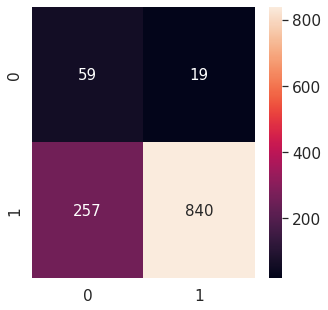

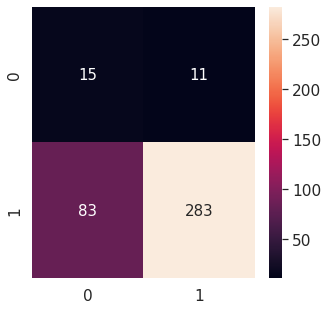

In [395]:
y_train_pred = grid.predict(X_train2_scaled)
y_test_pred = grid.predict(X_test2_scaled)

cm_train = confusion_matrix(y_train2.values.ravel(), y_train_pred)
cm_test = confusion_matrix(y_test2.values.ravel(), y_test_pred)

plot_cm(cm_train)
plot_cm(cm_test)

In [396]:
from sklearn.metrics import classification_report
print(classification_report(y_train2, y_train_pred))
print(classification_report(y_test2, y_test_pred))

              precision    recall  f1-score   support

           0       0.19      0.76      0.30        78
           1       0.98      0.77      0.86      1097

    accuracy                           0.77      1175
   macro avg       0.58      0.76      0.58      1175
weighted avg       0.93      0.77      0.82      1175

              precision    recall  f1-score   support

           0       0.15      0.58      0.24        26
           1       0.96      0.77      0.86       366

    accuracy                           0.76       392
   macro avg       0.56      0.68      0.55       392
weighted avg       0.91      0.76      0.82       392



## Further steps 
* Try with undersampling 
* Try with oversampling (SMOTE)
* More rigourous model training, feature selection and hyper-parameter tuning
* Tidy up code, use pipelines etc. 